# ML Training and Optimization

## Introduction

This notebook is dependent on the execution of `scripts/03 - data_preprocessing.py`

## Imports and Definitions

In [75]:
print("Starting Up")
import pandas as pd # Data manipulation
import sqlite3 # Database connection
import numpy as np # Numerical computation
import datetime # Date manipulation
import seaborn as sns # Plotting
import matplotlib.pyplot as plt # Plotting
import os # File manipulation
import yaml # Config file parsing
import argparse # Command line argument parsing
import sys
import warnings

# ML imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC as SupportVectorClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real

print("Defining Classes")
# Defining a class for logging messages to a file
class Logger:
    """
    A class for logging messages to a file.

    Attributes:
        config (dict): The configuration settings.
        log_dir (str): The directory for storing log files.
        tag (str): The tag for identifying the log files.
        file_path (str): The path to the log file.
        verbose (bool): Flag indicating whether to print log messages to the console.
    """
    def __init__(self, config):
        # Constructor to initialize the Logger instance
        self.config = config  # Store the provided configuration
        self.log_dir = config['logging']['out_dir']  # Directory to output logs
        self.tag = config['base']['tag']  # Tag for the log (e.g., identifying the run)
        # Construct the file path for the log file
        self.file_path = os.path.join('outputs', self.tag, self.log_dir, 'log.txt')
        self.verbose = config['logging']['verbose']  # Verbose flag to control output
        
    def log(self, message):
        """
        Logs a message to the log file.

        Args:
            message (str): The message to be logged.
        """
        # Method to log a message
        current_datetime = datetime.datetime.now()  # Get the current date and time
        # Format the datetime as a string
        datetime_string = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
        # Format the log message with a timestamp
        log_message = f"{datetime_string}: {message}"
        if self.verbose:
            # If verbose mode is on, print the log message to the console
            print(log_message)
        with open(self.file_path, "a") as f:
            # Open the log file in append mode and write the log message
            f.write(f'{log_message}\n')
            
print("Defining Functions")
def bestbandwidth(data):
    """
    Calculate the optimal bandwidth for kernel density estimation using the Silverman's rule of thumb.

    Parameters:
    data (array-like): The input data for which the bandwidth needs to be calculated.

    Returns:
    float: The optimal bandwidth value.

    """
    return 1.06*np.std(data)*len(data)**(-1/5)

def transform_type(sqlite_type):
    """
    Transforms the SQLite data type to a Python data type.

    Parameters:
    sqlite_type (str): The SQLite data type.

    Returns:
    str: The corresponding Python data type.
    """
    if sqlite_type == 'INTEGER':
        return 'int'
    if sqlite_type == 'REAL':
        return 'float'
    else:
        return 'object'

def map_dtype_to_sqlite(col_type):
    """
    Maps a column data type to the corresponding SQLite data type.

    Parameters:
        col_type (str): The column data type.

    Returns:
        str: The corresponding SQLite data type.

    """
    if col_type.startswith('int') or col_type == 'bool':
        return 'INTEGER'
    elif col_type.startswith('float'):
        return 'REAL'
    else:  # Default case, particularly for 'object' and other unhandled types
        return 'TEXT'

def time_formatting_function(time_delta):
    days = time_delta.days
    hours, remainder = divmod(time_delta.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)

    formatted_time = ""
    if days > 0:
        formatted_time += f"{days} days, "
    if hours > 0 or days > 0:  # Include hours if there are any days
        formatted_time += f"{hours} hours, "
    if minutes > 0 or hours > 0 or days > 0:  # Include minutes if there are any hours or days
        formatted_time += f"{minutes} minutes, "
    formatted_time += f"{seconds} seconds"

    return formatted_time

config_file_path = '../config/config.yml'

print(f"Reading Config File {config_file_path}")

# Open and read the configuration file using YAML
with open(config_file_path, 'r') as f:
    config = yaml.safe_load(f)

print("Defining Variables and Creating Directories")

sqlite_file = config['data']['output_sqlite']

tag = config['base']['tag']

git_repo = config['base']['git_repo']

fontsize = config['plotting']['fontsize']
figsize_x = config['plotting']['figure_xsize']
figsize_y = config['plotting']['figure_ysize']
bayes_search_iterations = config['machine_learning']['bayes_search_iterations']
random_state = config['machine_learning']['random_state']
algorithms = config['machine_learning']['algorithms']
n_jobs = config['machine_learning']['n_jobs']

optimization_sample_size = config['machine_learning']['optimization_sample_size']

out_dir_figures = f"../outputs/{tag}/figures"
out_dir_log = f"../outputs/{tag}/log"
out_dir_stats = f"../outputs/{tag}/stats"

sqlite_file = f"../outputs/{tag}/data/{sqlite_file}"

columns_of_interest = config['base']['columns_of_interest']

print("Done with Imports and Definitions")

Starting Up
Defining Classes
Defining Functions
Reading Config File ../config/config.yml
Defining Variables and Creating Directories
Done with Imports and Definitions


## Loading Full and Sample Data

In [76]:
print("Loading Data")
# Defining the connection to the database
conn = sqlite3.connect(sqlite_file)

# Loading data into dataframe
data_fetch_query = f"""SELECT * 
                       FROM loans_data_ML"""

loans_data = pd.read_sql_query(data_fetch_query, conn, index_col='id')

# Loading data into dataframe
data_fetch_query = f"""SELECT id, total_pymnt
                       FROM loans_data"""

loans_data_paymnts = pd.read_sql_query(data_fetch_query, conn)

loans_data_paymnts = loans_data_paymnts[loans_data_paymnts['id'].apply(lambda x: x in loans_data.index)]

combined_data = pd.merge(loans_data, loans_data_paymnts, on='id', how='inner')
combined_data['Profit_or_Loss'] = combined_data['total_pymnt'] - combined_data['loan_amnt']

# Closing connection
conn.close()

print("Done Loading Full and Sample Data")

Loading Data


KeyboardInterrupt: 

## Separating sample data for ML hyperparameter optimization

In [ ]:
sample_data = combined_data.sample(optimization_sample_size, random_state=random_state)

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    # Since we're setting this at the sys level, it should not be overridden
    os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses
   
X_opt, y_opt = sample_data.drop('loan_status', axis='columns'), sample_data['loan_status']

X, y = combined_data.drop('loan_status', axis='columns'), combined_data['loan_status']

ML_columns = loans_data.drop('loan_status', axis='columns').columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

X_train, X_train_profit_or_loss = X_train.drop(['id', 'total_pymnt', 'Profit_or_Loss'], axis='columns'), X_train['Profit_or_Loss']

X_opt, X_opt_profit_or_loss = X_opt.drop(['id', 'total_pymnt', 'Profit_or_Loss'], axis='columns'), X_opt['Profit_or_Loss']

cummulative_results = None

average_profit_0 = np.mean(combined_data[combined_data['loan_status'] == 0]['Profit_or_Loss'])
average_profit_1 = np.mean(combined_data[combined_data['loan_status'] == 1]['Profit_or_Loss'])

print("Done with Separating sample data for ML hyperparameter optimization")

## Defining Profit Scorer and Callback Function

In [ ]:
def profit_scorer(y, y_pred_proba):
    # Compute probabilities for class at position [1]
    probabilities = y_pred_proba
    
    # Assuming X_profit_or_loss is globally accessible and represents the profit or loss for each instance
    global average_profit_0, average_profit_1

    profit_or_loss_array = average_profit_0*(1-y) + average_profit_1*y
    # Initialize profits array
    profits = np.zeros(50)
    for i, thresh in enumerate(np.linspace(0, 1, 50)):
        # Calculate profit for each threshold
        profits[i] = profit_or_loss_array[probabilities <= thresh].sum()
    # Calculate and return max relative profit
    max_relative_profit = np.max(profits) / np.sum(profit_or_loss_array)
    return max_relative_profit

def callback(res):
    global time_start
    global logger
    global bayes_search_iterations
    global algorithm

    time_elapsed = datetime.datetime.now() - time_start
    eta = time_elapsed / len(res.x_iters) * bayes_search_iterations - time_elapsed

    logger.log(f"Iteration {len(res.x_iters)} / {bayes_search_iterations} for {algorithm}")
    logger.log(f"Time Elapsed: {time_formatting_function(time_elapsed)}")
    logger.log(f"ETA: {time_formatting_function(eta)}")
    logger.log(f"Best Score so far: {np.max(-res.func_vals)}")
    logger.log(f"Best Parameters so far: {res.x_iters[np.argmax(-res.func_vals)]}")
    logger.log(f"Current Parameters: {res.x}")
    logger.log(f'Average score: {np.mean(-res.func_vals)}')

max_profit_scorer = make_scorer(profit_scorer, greater_is_better=True, needs_proba=True)

print("Done with Defining Profit Scorer")

In [83]:
param_grid = {
    'C': Real(1e-10, 1e10, 'log-uniform'),
    'solver': ['lbfgs'],
    'penalty': ['l2'],
    'class_weight': ['balanced'],
    'max_iter': [1000000]
    }
for value in param_grid.values():
    type_str = str(type(value))
    if type_str != "<class 'list'>":
        break

1e-10

## ML Hyperparameter Optimization

Optimizing RandomForestClassifier Hyperparameters
Time Elapsed: 3 seconds
ETA: 14 seconds
Iteration 1 / 5
Best Score so far: 1.8813611545906352
Best Parameters so far: [False, 'balanced', 'gini', 32, 'sqrt', 5, 19, 301, 42]
Time Elapsed: 4 seconds
ETA: 6 seconds
Iteration 2 / 5
Best Score so far: 1.8813611545906352
Best Parameters so far: [False, 'balanced', 'gini', 32, 'sqrt', 5, 19, 301, 42]
Time Elapsed: 7 seconds
ETA: 5 seconds
Iteration 3 / 5
Best Score so far: 1.8976095753713063
Best Parameters so far: [False, 'balanced', 'entropy', 44, 'log2', 5, 9, 318, 42]
Time Elapsed: 11 seconds
ETA: 2 seconds
Iteration 4 / 5
Best Score so far: 1.9397457664934117
Best Parameters so far: [True, 'balanced', 'gini', 80, 'sqrt', 2, 38, 556, 42]
Time Elapsed: 13 seconds
ETA: 0 seconds
Iteration 5 / 5
Best Score so far: 1.9397457664934117
Best Parameters so far: [True, 'balanced', 'gini', 80, 'sqrt', 2, 38, 556, 42]
Plotting Results for RandomForestClassifier Hyperparameter Optimization
Optimizing

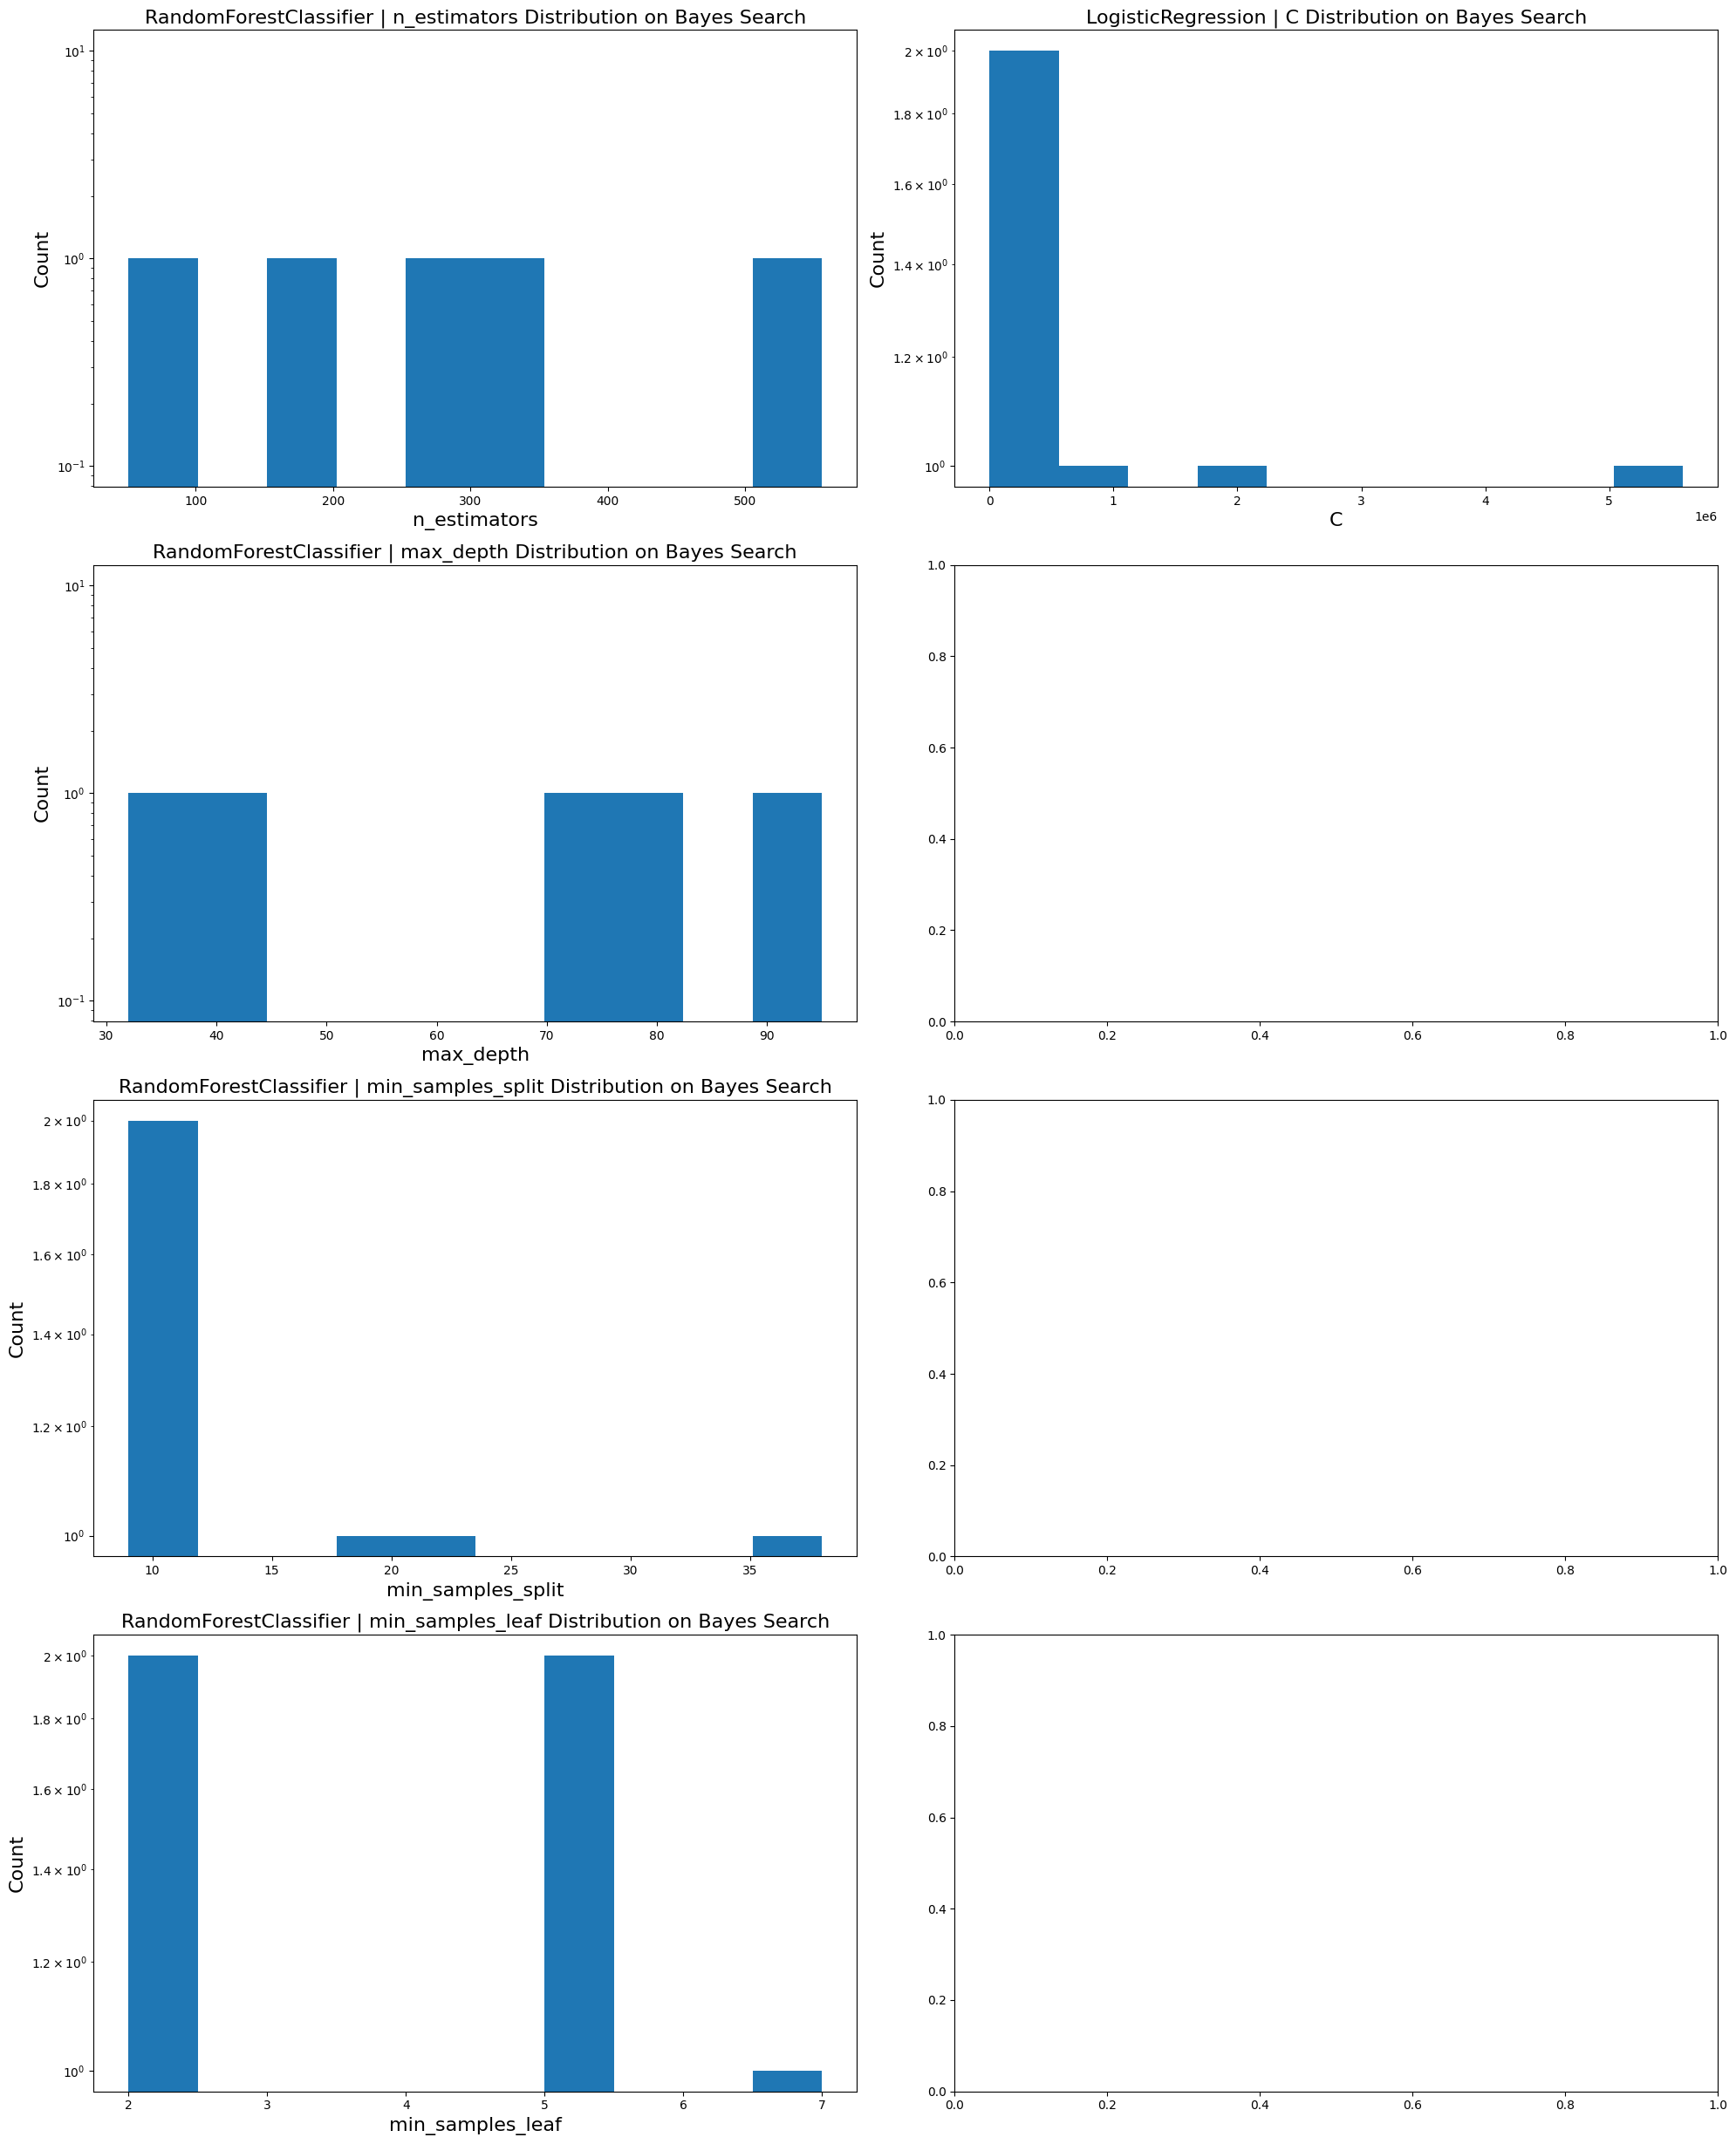

In [127]:
param_grids = {"LogisticRegression":{
                    'C': Real(1e-10, 1e10, 'log-uniform'),
                    'solver': ['lbfgs'],
                    'penalty': ['l2'],
                    'class_weight': ['balanced'],
                    'max_iter': [1000000],
                    'random_state': [random_state]
                    },
              "RandomForestClassifier":{
                    'n_estimators': Integer(10, 1000, 'log-uniform'),
                    'criterion': Categorical(['gini', 'entropy']),
                    'max_features': Categorical(['sqrt', 'log2']),
                    'max_depth': Integer(1, 100),
                    'min_samples_split': Integer(2, 50),
                    'min_samples_leaf': Integer(1, 10),
                    'bootstrap': Categorical([True, False]),
                    'class_weight': ['balanced'],
                    'random_state': [random_state]
                    },
               "SupportVectorClassifier":{
                    'C': Real(1e-6, 1e+6, 'log-uniform'),
                    'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
                    'degree': Integer(1, 5),  # only used with 'poly' kernel
                    'gamma': Categorical(['scale', 'auto']),
                    'class_weight': ['balanced'],
                    'probability': [True],
                    'random_state': [random_state]
               }}

def is_numerical_param(param):
    return (str(type(param)) != "<class 'list'>") and (str(type(param)) != "<class 'skopt.space.space.Categorical'>")

initial_params = {algorithm:{key: value[0] for key, value in param_grids[algorithm].items() if str(type(value)) == "<class 'list'>"} for algorithm in param_grids.keys()}
n_num_params_dict = {algorithm:0 for algorithm in algorithms}
for algorithm in algorithms:
    param_grid = param_grids[algorithm]
    for value in param_grid.values():
        if is_numerical_param(value):
            n_num_params_dict[algorithm] += 1

n_num_params = np.max([i for i in n_num_params_dict.values()])

fig, ax = plt.subplots(n_num_params, len(algorithms), figsize = [len(algorithms)*figsize_x, n_num_params*figsize_y])


for i, algorithm in enumerate(algorithms):
    print(f"Optimizing {algorithm} Hyperparameters")
    param_grid = param_grids[algorithm]
    ini_params = initial_params[algorithm]
    if algorithm == "LogisticRegression":
        clf = LogisticRegression(**ini_params)
    elif algorithm == "RandomForestClassifier":
        clf = RandomForestClassifier(**ini_params) 
    elif algorithm == "SupportVectorClassifier":
        clf = SupportVectorClassifier(**ini_params)


    grid_search = BayesSearchCV(estimator=clf,
                                    search_spaces=param_grid,
                                    cv=5,
                                    verbose=False,
                                    scoring=max_profit_scorer,
                                    n_iter=bayes_search_iterations,
                                    n_jobs=n_jobs,
                                    random_state=random_state)
    
    time_start = datetime.datetime.now()

    np.int = int 
    grid_search.fit(X_opt, y_opt, callback=callback)

    results = pd.DataFrame(grid_search.cv_results_)
    results['ML_model'] = [algorithm]*len(results)

    if cummulative_results is None:
        cummulative_results = results.copy()
    else:
        cummulative_results = pd.concat([cummulative_results, results.copy()])

    print(f"Plotting Results for {algorithm} Hyperparameter Optimization")

    for j, param in enumerate([key for key, value in param_grid.items() if is_numerical_param(value)]):
        x_plot = results['params'].apply(lambda x: x[param])
        ax[j, i].hist(x_plot)
        ax[j, i].set_yscale('log')
        ax[j, i].set_xlabel(param, fontsize=fontsize)
        ax[j, i].set_ylabel(f'Count', fontsize=fontsize)
        ax[j, i].set_title(f'{algorithm} | {param} Distribution on Bayes Search', fontsize=fontsize)
  
fig.tight_layout()
fig.savefig(os.path.join(out_dir_figures, "BayesSearchCV_parameter_Distributions.png"))

clear_output(wait=True)
plt.show()

## Plotting Grid Search Results

In [124]:
best_bw = bestbandwidth(cummulative_results['mean_test_score'].values)
maxX = cummulative_results['mean_test_score'].max()
minX = cummulative_results['mean_test_score'].min()
nBins = int((maxX - minX)/best_bw)
bins = np.linspace(minX, maxX, nBins)

fig, ax = plt.subplots(figsize=[figsize_x, figsize_y])

for algorithm in algorithms:
    data = cummulative_results[cummulative_results['ML_model'] == algorithm]['mean_test_score']
    sns.histplot(data, kde=True, label=algorithm, ax=ax, bins=bins, element='step')
    
ax.set_xlabel("Mean Relative Profit Score", fontsize=fontsize)
ax.set_ylabel("Count", fontsize=fontsize)
ax.set_title("Distribution of Test Scores in Bayesian Search For Each Machine Learning Algorithm", fontsize=fontsize)
ax.legend()
fig.tight_layout()

print("Done!")

Real(low=1e-10, high=10000000000.0, prior='log-uniform', transform='normalize')
